# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

# Implementation
## Use Google Colab with GPU to reproduce result

## Upload text8.zip please before run next cell

In [274]:
!rm ./text8
!unzip ./text8.zip

Archive:  ./text8.zip
  inflating: text8                   


## All imports here

In [0]:
import torch
from torch import nn
import torch.optim as optim

from collections import Counter
import numpy as np

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from tsnecuda import TSNE
from sklearn import preprocessing

from annoy import AnnoyIndex

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Batcher for Skip-Gram or CBOW from previous assigment
- torch.tensor instead of np.array used

In [0]:
class Batcher():
    def __init__(self, text, limit=5, window_size=2, mode='sg'):
        """
        Batcher for Skip-Gram or CBOW

        :param text: String without newline symbols
        :param limit: Don't put words with less amount into the dictonary
        :param window_size: Window size ^)
        :param mode: cbow or sg
        """

        self.limit = limit
        self.window_size = window_size
        self.mode = mode

        self.text = text

        self.UNK = 'UNK'

        self.tokens = []
        self.tokens_ind = []


        self.vocabulary = set()
        self.word2index = dict()
        self.index2word = []

        self.most_common = []

        self._preprocess()

    @classmethod
    def from_file(cls, path, limit=5, window_size=2, mode='sg'):
        """
        Init Batcher from file

        :param path: Path to text file
        :param limit: Don't put words with less amount into the dictonary
        :param window_size: Window size ^)
        :param mode: cbow or sg
        :return: Batcher object
        """
        n = -1
        with open(path) as f:
            text = f.read(n)

        return cls(text, limit, window_size, mode)

    def _clean(self):
        # Everething expect [a-z ] already killed in our dataset
        pass

    def _tokenize(self):
        # Stupid tokenizer for our dataset
        self.tokens = self.text.split()

    def _build_vocabulary(self):
        counter_words = Counter(self.tokens)
        self.counter_words = counter_words
        self.vocabulary = {word for word, counts in counter_words.items() if counts >= self.limit}
        most_common = counter_words.most_common(200)
        self.most_common = list(zip(*most_common))[0]

    def _numericalize(self):
        self.index2word = [self.UNK] + list(self.vocabulary)
        self.vocabulary.add(self.UNK)
        self.word2index = dict(zip(self.index2word, range(len(self.index2word))))
        self.tokens_ind = [self.word2index.get(word, 0) for word in self.tokens]

    def _preprocess(self):
        self._clean()
        self._tokenize()
        self._build_vocabulary()
        self._numericalize()

    def indices2words(self, indices):
        shape = indices.shape
        result = np.array([self.index2word[idx] for idx in indices.flatten()])
        return result.reshape(shape)

    def batch_generator(self, batch_size=5):
        """
        Batch generator

        :param batch_size: Elements in batch
        :return: Next batch
        """

        # Dataset is big enought
        # Let's skip last nonfull batch if exist
        count_batches = (len(self.tokens) - 2 * self.window_size) // batch_size
        print(f'count batches: {count_batches}')

        for batch_id in range(count_batches):
            batch_x = []
            batch_label = []
            for step_id in range(batch_size):
                pos_word_central = step_id + self.window_size + batch_id * batch_size
                x = self.tokens_ind[pos_word_central]
                batch_x.append(x)
                label_left = self.tokens_ind[pos_word_central - self.window_size : pos_word_central]
                label_right = self.tokens_ind[pos_word_central + 1 : pos_word_central + 1 + self.window_size]
                label = label_left + label_right
                batch_label.append(label)

            batch_x = torch.tensor(batch_x)
            batch_label = torch.tensor(batch_label)
            if self.mode == 'cbow':
                batch_x, batch_label = batch_label, batch_x
            yield batch_x, batch_label

# NegativeSamplingBatcher


In [0]:
class NegativeSamplingBatcher(Batcher):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.counter_words = {}
        # self.probabilities = np.array

    #ToDo Update parent class method
    def _build_vocabulary(self):
        counter_words = Counter(self.tokens)
        self.counter_words = counter_words
        self.vocabulary = {word for word, counts in counter_words.items() if counts >= self.limit}
        most_common = counter_words.most_common(200)
        self.most_common = list(zip(*most_common))[0]

    def _preprocess(self):
        super()._preprocess()
        self._count_distribution()

    def _count_distribution(self):
        frequencies = np.array([self.counter_words[word] for word in self.index2word])
        frequencies = frequencies ** (3/4)
        self.probabilities = frequencies / np.sum(frequencies)

    def get_negative_samples(self, samples=5):
        return torch.from_numpy(np.random.choice(len(self.probabilities), size=samples, p=self.probabilities))
    

## Settings for batcher

In [0]:
window_size = 3
batch_size = 256
limit4dictonary = 10
mode='cbow'

## Batcher initialization

In [0]:
batcher = NegativeSamplingBatcher.from_file(path='./text8', limit=limit4dictonary, window_size=window_size, mode=mode)
batch_generator = batcher.batch_generator(batch_size)

## NN to train CBOW_NS word2wec

In [0]:
class CBOW_NS(nn.Module):
    def __init__(self, size_vocab, size_emb):
        super().__init__()

        self.emb = nn.Embedding(size_vocab, size_emb)
        self.out = nn.Linear(size_emb, size_vocab, bias=False)
        self.sm = nn.LogSoftmax(dim=0)

    def forward(self, batch_x):
        batch_x = self.emb(batch_x)
        out = self.sm(self.out(batch_x)) 
        return out

## Model and training settings

In [281]:
size_vocab = len(batcher.vocabulary)
size_emb = 300
learning_rate = 0.002
epochs = 3
print_every = 300

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [0]:
model = CBOW_NS(size_vocab=size_vocab, size_emb=size_emb)
model = model.to(device=device)

optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
fnc_loss = nn.NLLLoss()

## Training word vectors
- No early stopping used
- No learning rate decreasing used
- One hrs to deadline... No time to realize matrix version.... Khm! Let's use two losses!

In [283]:
#Some magic to mention somewhere, how long it took to train

%%time

batches2plot = []
losses2plot = []
j = 0
try:
    for epoch in range(epochs):
        i = 0
        loss2print = 0
        for batch_idx, (batch_x, batch_labels) in enumerate(batcher.batch_generator(batch_size)):
            batch_x = batch_x.to(device=device, dtype=torch.long)
            batch_labels = batch_labels.to(device=device, dtype=torch.long)

            batch_x_neg = batcher.get_negative_samples(batch_size)
            batch_x_neg = batch_x_neg.to(device=device, dtype=torch.long)

            optimizer.zero_grad()

            labels_pred = model(batch_x)


            labels_pred_neg = model(batch_x_neg)
            loss_neg = -fnc_loss(labels_pred_neg, batch_labels)
            loss_neg /= batch_size
            loss_neg.backward()


            batch_labels = batch_labels.reshape(-1, 1).expand(-1, batch_x.size()[1]).flatten()
            labels_pred = labels_pred.reshape(-1, labels_pred.shape[-1])
            loss = fnc_loss(labels_pred, batch_labels)

            

            loss.backward()
            optimizer.step()
            loss2print += float(loss)
            i+=1

            if batch_idx % print_every == 0:
                loss2print = loss2print / i
                batches2plot.append(j * print_every)
                j += 1
                losses2plot.append(loss2print)

                print(f'Epoch: {epoch} Iteration: {batch_idx}, loss = {loss2print}')
                i = 0
                loss2print = 0
except KeyboardInterrupt:
    print('Training Stopped')

count batches: 66426
Epoch: 0 Iteration: 0, loss = 5.716185092926025
Epoch: 0 Iteration: 300, loss = 5.591639102300008
Epoch: 0 Iteration: 600, loss = 5.588959948221842
Epoch: 0 Iteration: 900, loss = 5.579988498687744
Epoch: 0 Iteration: 1200, loss = 5.580705803235372
Epoch: 0 Iteration: 1500, loss = 5.597194746335347
Epoch: 0 Iteration: 1800, loss = 5.578658475875854
Epoch: 0 Iteration: 2100, loss = 5.5929874308904015
Epoch: 0 Iteration: 2400, loss = 5.569928046862285
Epoch: 0 Iteration: 2700, loss = 5.600867609977723
Epoch: 0 Iteration: 3000, loss = 5.557397723197937
Epoch: 0 Iteration: 3300, loss = 5.59805239200592
Training Stopped
CPU times: user 1min 23s, sys: 49.9 s, total: 2min 12s
Wall time: 2min 13s


# Plotted Loss

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Batch')]

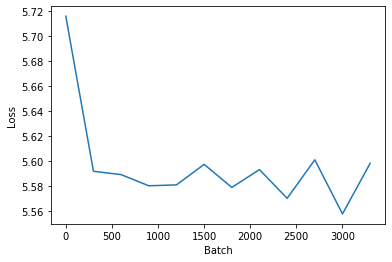

In [284]:
sns.lineplot(batches2plot, losses2plot).set(xlabel='Batch', ylabel='Loss')